## Librarys importeren

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.dummy import DummyClassifier
from copy import deepcopy

%run data-cleaning.ipynb

C:\Users\casja\AppData\Local\Temp\ipykernel_18012\2333577348.py:42: DtypeWarning: Columns (0,8,11,12,13,17,20,21,26,37,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\GitHub\jaar 2\groeps project prorail\dataset-prorail-clean-2.csv")


In [ ]:
pd.set_option('display.max_columns', None)  # Toon alle kolommen
pd.set_option('display.max_rows', None)     # Toon alle rijen als dat nodig is
pd.set_option('display.max_colwidth', None) # Toon volledige inhoud van elke kolom
# df = pd.read_csv(r"C:\GitHub\jaar 2\blok 1\groeps project proraills\dataset-prorail-clean-2.csv") pc
df = pd.read_csv(r"C:\GitHub\jaar 2\groeps project prorail\dataset-prorail-clean-2.csv") #laptop
# df = pd.read_csv(r"dataset-prorail-clean-2.csv")
dfNotCleaned = deepcopy(df)
df = clean_data(df)
# dfNotCleaned.head()
df.head()

C:\Users\casja\AppData\Local\Temp\ipykernel_18012\2493185433.py:5: DtypeWarning: Columns (0,8,11,12,13,17,20,21,26,37,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\GitHub\jaar 2\groeps project prorail\dataset-prorail-clean-2.csv") #laptop


## Data Analysis
In this section, we present the columns that have undergone cleaning. These are the columns we plan to use for model development. Additionally, some columns included here may not be used in the models but could still provide useful insights.

In [6]:
# Ensure all columns and rows are displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Calculate the total number of rows
total_rows = len(df)

# Create a DataFrame summarizing missing values
missing_values_summary = pd.DataFrame({
    'Column Name': dfNotCleaned.columns,
    'Missing Values': dfNotCleaned.isnull().sum(),
    'Total Values': total_rows
})

# Calculate the percentage of missing values and round it for readability
missing_values_summary['Percentage Missing'] = ((missing_values_summary['Missing Values'] / missing_values_summary['Total Values']) * 100).round(2)

# Filter to include only columns with missing values
missing_values_summary = missing_values_summary[missing_values_summary['Missing Values'] > 0]

# Print the summary in a more readable format
print("\nMissing Values Summary (Only Columns with Missing Values):\n")
print(missing_values_summary.to_string(index=False, col_space=20))


Missing Values Summary (Only Columns with Missing Values):

             Column Name       Missing Values         Total Values   Percentage Missing
             stm_geo_mld                   54               392007                 0.01
         stm_aanngeb_ddt                  859               392007                 0.22
             stm_geo_gst                45503               392007                11.61
          stm_oorz_groep                27408               392007                 6.99
           stm_oorz_code                27397               392007                 6.99
              stm_fh_ddt                24236               392007                 6.18
           stm_fh_status                22624               392007                 5.77
    stm_sap_storeind_ddt                54043               392007                13.79
stm_tao_indicator_vorige               310876               392007                79.30
   stm_tao_soort_mutatie               326076              

We observe that several columns have a significant percentages of missing values, particularly `stm_tao_indicator_vorige` and `stm_tao_soort_mutatie`, which have missing rates of 79.30% and 83.18%, respectively. We are probably not going to use these columns because of the high amount of missing values, which could impact our model. Therefore, we may need to consider strategies for handling these missing values, such as replacing the missing values with the mean or removal of columns, depending on their relevance to our models.

## Graphs
We have made a graph here so that you can see what types of problems are in the database.

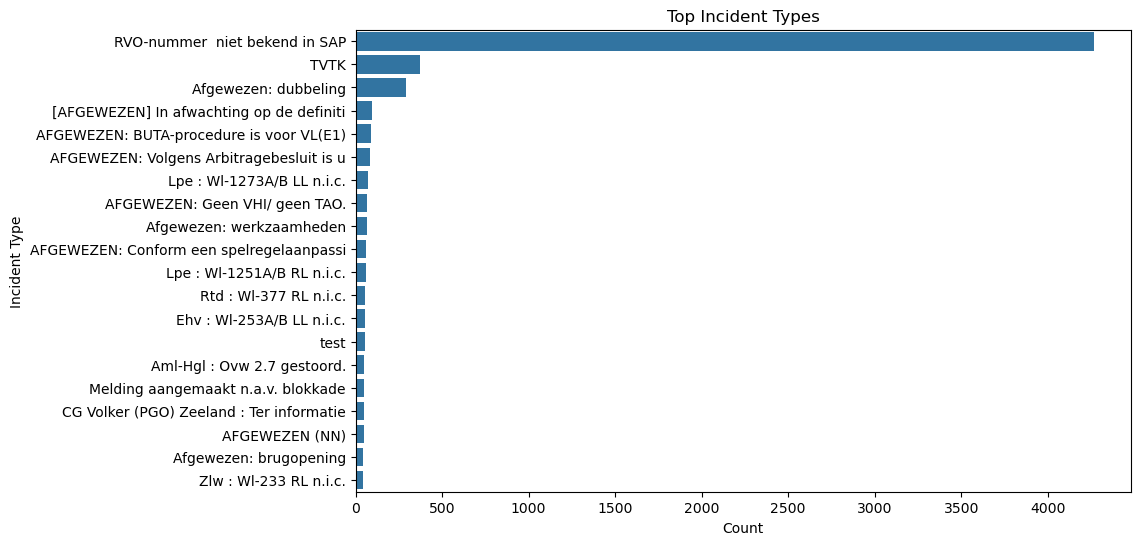

In [14]:
top_n = 20  # Adjust this number as needed
top_incidents = dfNotCleaned['stm_sap_meldtekst'].value_counts().nlargest(top_n)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_incidents.index, x=top_incidents.values)
plt.title("Top Incident Types")
plt.xlabel("Count")
plt.ylabel("Incident Type")
plt.show()


As you can see, most of them are not known. We are not sure why this is. But since these are string values we can't use them in our model.

From now on we will use the fully cleaned data for further understanding and analysis. We will start by understanding the distribution of the data.

For now we will bin the duration it takes for "functie herstel" to take place using bins of equal width (except the first 2). We do this because these will be the classes we will try to predict. 

Eventually we wan't to use frequancy binning so the first few bins can be predicted more accurately. (accuracy in the sense of less time span)

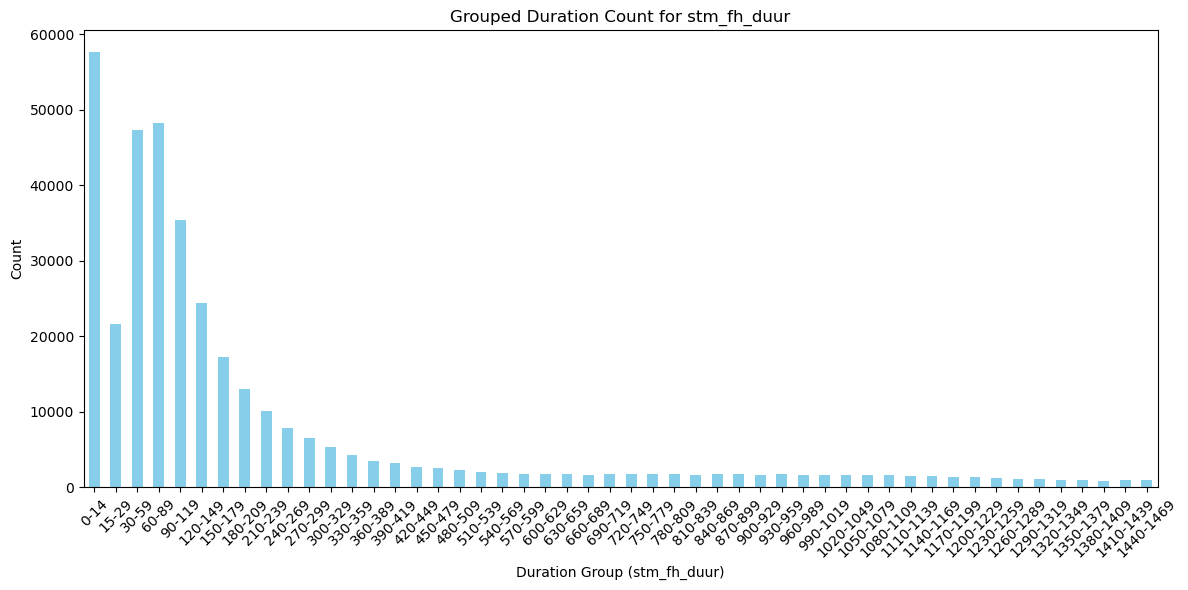

Aantal bins van 30: 1440.0


In [19]:
# Convert stm_fh_duur to numeric, setting errors='coerce' will replace non-numeric values with NaN
df['stm_fh_duur'] = pd.to_numeric(df['stm_fh_duur'], errors='coerce')

# Define new bins with 0-14 and 15-29 for the first two ranges, then continue with 30-59, 60-89, etc.
bins = [0, 15, 30] + list(range(60, int(df['stm_fh_duur'].max(skipna=True)) + 30, 30))
labels = ["0-14", "15-29"] + [f"{i}-{i+29}" for i in range(30, int(df['stm_fh_duur'].max(skipna=True)), 30)]

# Create a new column for the binned df
df['stm_fh_duur_grouped'] = pd.cut(df['stm_fh_duur'], bins=bins, labels=labels, right=False)

# Count the occurrences in each bin, dropping NaN values in 'stm_fh_duur_grouped'
grouped_counts = df['stm_fh_duur_grouped'].value_counts().sort_index()

# Set the number of bins to display
n_bins = 50  # Adjust this to control how many bins to display in the chart

# Plot the bar chart
plt.figure(figsize=(12, 6))
grouped_counts.head(n_bins).plot(kind='bar', color='skyblue')
plt.xlabel('Duration Group (stm_fh_duur)')
plt.ylabel('Count')
plt.title('Grouped Duration Count for stm_fh_duur')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Convert stm_fh_duur to numeric, setting errors='coerce' will replace non-numeric values with NaN
df['stm_fh_duur'] = pd.to_numeric(df['stm_fh_duur'], errors='coerce')

# Bereken de maximale waarde in de kolom
max_value = df['stm_fh_duur'].max(skipna=True)

# Bereken het aantal bins van 30
bin_size = 30
num_bins = (max_value // bin_size) + 1  # Aantal bins, voeg 1 toe voor het 0-interval

# Print het totale aantal bins
print(f"Aantal bins van 30: {num_bins}")

We have chosen to display the time this way so that we can make better estimates for shorter problems. Since most issues are brief, we believe this is the best approach.

Below, we have provided a correlation table so that you can easily see the correlation between the columns that we may use for our models.

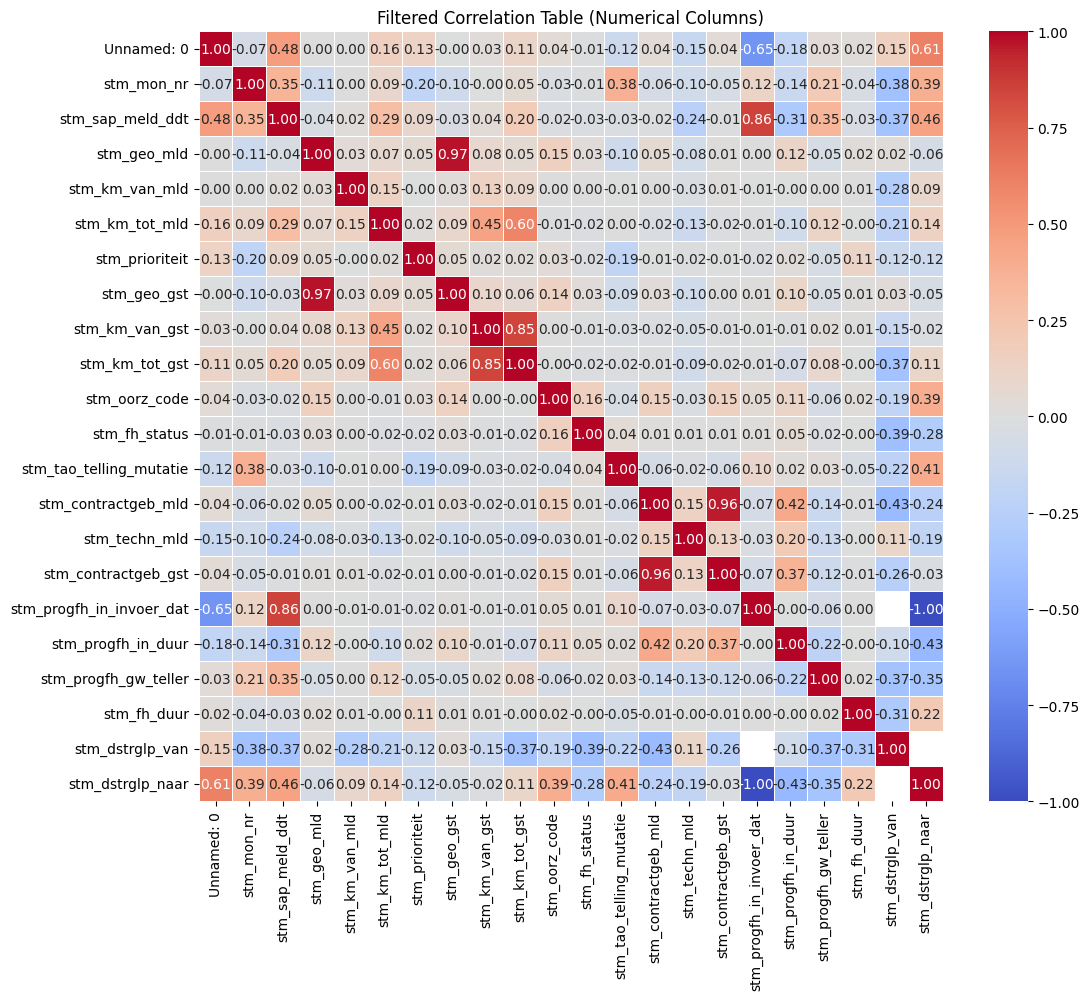

In [12]:
# Probeer zoveel mogelijk kolommen om te zetten naar numeriek en retourneer een nieuwe DataFrame
def convert_to_numeric(df):
    new_df = df.copy()  # Maak een kopie van de originele DataFrame
    for column in new_df.columns:
        # Probeer elke kolom om te zetten naar een numeriek type
        new_df[column] = pd.to_numeric(new_df[column], errors='coerce')
    return new_df

# Converteer alle kolommen naar numeriek waar mogelijk en maak een nieuwe DataFrame
numeric_df = convert_to_numeric(df)

# Selecteer alleen numerieke kolommen voor de correlatiematrix
numeric_df_filtered = numeric_df.select_dtypes(include=['number'])

# Verwijder kolommen met constante waarden
numeric_df_filtered = numeric_df_filtered.loc[:, (numeric_df_filtered != numeric_df_filtered.iloc[0]).any()]

# Bereken de correlatiematrix op de gefilterde gegevens
correlation_table = numeric_df_filtered.corr()

# Filter de correlatiematrix op een correlatiedrempel (bijv. 0.1)
threshold = 0.1
correlation_table_filtered = correlation_table[(correlation_table.abs() >= threshold).any(axis=1)]
correlation_table_filtered = correlation_table_filtered.loc[:, (correlation_table_filtered.abs() >= threshold).any(axis=0)]

# Controleer of er gegevens zijn om te plotten
if not correlation_table_filtered.empty:
    # Plot de gefilterde correlatiematrix met minder decimalen
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_table_filtered, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Filtered Correlation Table (Numerical Columns)')
    plt.show()
else:
    print("Geen relevante correlaties om te plotten.")


As you can see, there are some columns that correlate with each other, but most importantly is the correlation with `stm_fh_duur` since this is our target variable. With this one only 2 are midly correlated, which are `stm_dstrglp_naar` and `stm_prioriteit`.

## Baseline
Below, we have created three baselines that we can use for comparison with our models.

In [1]:
#Baseline model
averageFHDuration = df['stm_fh_duur'].mean()
averageFHDurationBin = np.digitize(averageFHDuration, bins)
print("Average duration of a fault:", averageFHDuration, "with label:", labels[averageFHDurationBin - 1])

#calculate accuracy average duration with the bins
baselineAccuracy = (df['stm_fh_duur_grouped']==labels[averageFHDurationBin - 1]).sum()/len(df)
print("Baseline accuracy:", baselineAccuracy*100)

# Second baseline
baselineAccuracy2 = (df['stm_fh_duur_grouped']==labels[0]).sum()/len(df)
print("Baseline accuracy2:", baselineAccuracy2*100)

feutureVariables = df[['stm_geo_mld', 'stm_prioriteit', 'stm_oorz_code', 'stm_contractgeb_gst', 'stm_mon_nr', 'stm_sap_meld_ddt', 'stm_km_van_mld', 'stm_km_tot_mld']]
targetVariable = df['stm_fh_duur_grouped']
baselineModel = DummyClassifier(strategy='most_frequent', random_state=0)
baselineModel.fit(feutureVariables, targetVariable)
print("Baseline accuracy3:", baselineModel.score(feutureVariables, targetVariable)*100)



NameError: name 'df' is not defined

We chose baselineAccuracy2 as a benchmark to evaluate model performance because it measures how well our model predicts using the reference label, labels[0]. It is calculated by comparing the stm_fh_duur_grouped column with labels[0], which is the most common label. After which we count the correct predictions and divide it by the total sum of datapoints. This results in a accuracy of about `14.7%`. This baseline allows us to assess more models against a reference point.